In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


In [2]:
df=pd.read_csv("GlobalLandTemperaturesByCountry.csv")
df = df.rename(columns={'dt': 'Date'})
df

,Date,AverageTemperature,AverageTemperatureUncertainty,Country
0,1743-11-01,4.384,2.294,Åland
1,1743-12-01,NaN,NaN,Åland
2,1744-01-01,NaN,NaN,Åland
3,1744-02-01,NaN,NaN,Åland
4,1744-03-01,NaN,NaN,Åland
...,...,...,...,...
577457,2013-05-01,19.059,1.022,Zimbabwe
577458,2013-06-01,17.613,0.473,Zimbabwe
577459,2013-07-01,17.000,0.453,Zimbabwe
577460,2013-08-01,19.759,0.717,Zimbabwe


In [3]:
td = df[df["Country"]=="Turkey"]
td = td.dropna()
td['Date'] = pd.to_datetime(td['Date'])
numeric_columns = td[["Date", "AverageTemperature", "AverageTemperatureUncertainty"]]
td

,Date,AverageTemperature,AverageTemperatureUncertainty,Country
533683,1777-02-01,3.000,3.314,Turkey
533685,1777-04-01,7.678,2.553,Turkey
533686,1777-05-01,15.293,3.189,Turkey
533687,1777-06-01,18.661,2.993,Turkey
533688,1777-07-01,20.757,2.643,Turkey
...,...,...,...,...
536517,2013-04-01,12.102,0.259,Turkey
536518,2013-05-01,17.522,0.360,Turkey
536519,2013-06-01,20.862,0.240,Turkey
536520,2013-07-01,23.335,0.281,Turkey


In [4]:
corr_matrix=numeric_columns.corr()

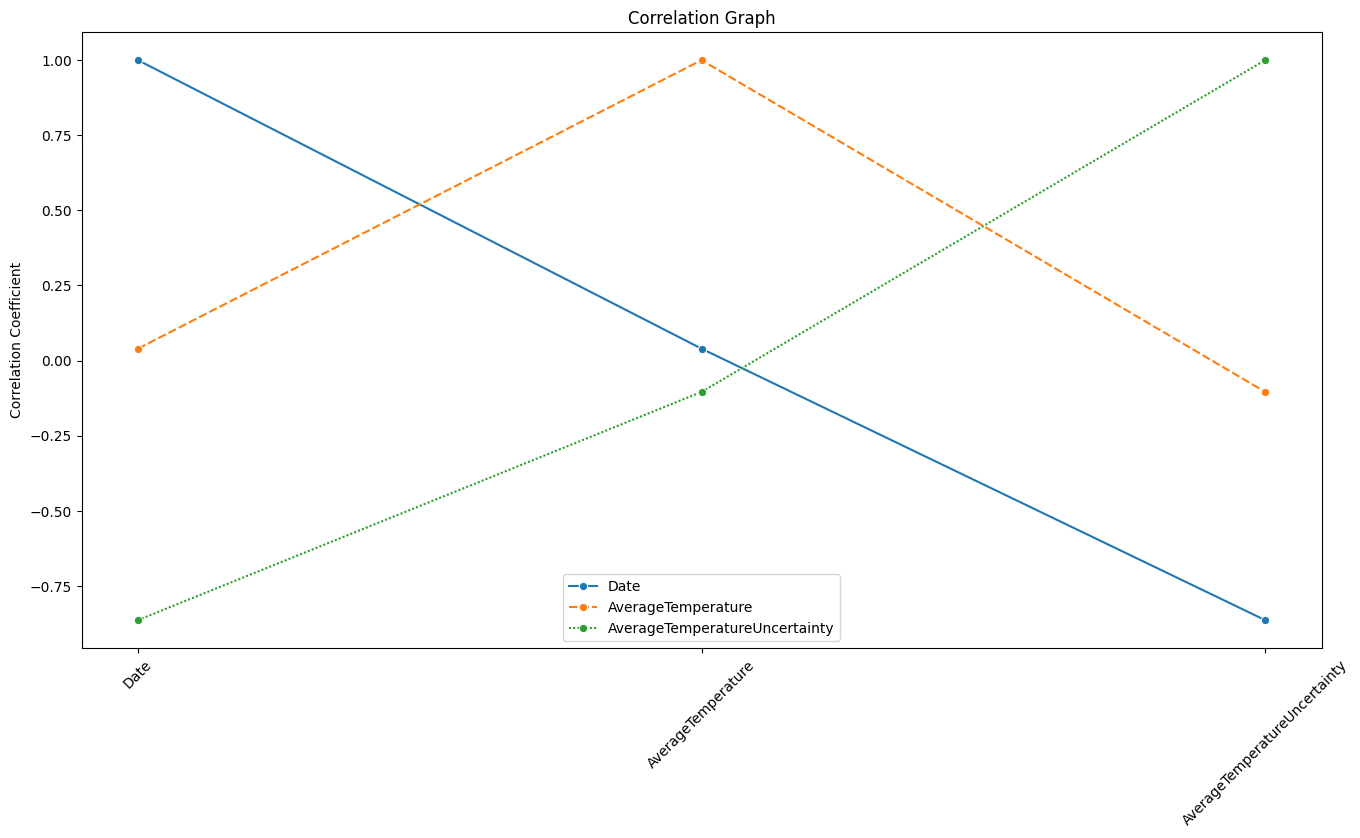

In [5]:
plt.figure(figsize=(16, 8))
sns.lineplot(data=corr_matrix, marker="o")
plt.title('Correlation Graph')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

In [6]:
time_series_data = td[['Date', 'AverageTemperature']]
time_series_data.set_index('Date', inplace=True)

In [7]:
result = adfuller(time_series_data['AverageTemperature'])
if result[1] > 0.05:
    print("Time series is not stationary. Applying differencing...")
    
    time_series_data['Temperature_diff'] = time_series_data['AverageTemperature'] - time_series_data['AverageTemperature'].shift(1)
    
    time_series_data = time_series_data.dropna()

In [8]:
train_data, test_data = train_test_split(time_series_data, test_size=0.2, shuffle=False)

In [9]:
arima_order = (2, 1, 4)  
arima_model = ARIMA(train_data['AverageTemperature'], order=arima_order)
arima_result = arima_model.fit()

In [10]:
predictions = arima_result.forecast(steps=len(test_data))

In [11]:
rmse = np.sqrt(mean_squared_error(test_data['AverageTemperature'], predictions))
print(f"RMSE: {rmse}")

RMSE: 1.7073745938073996


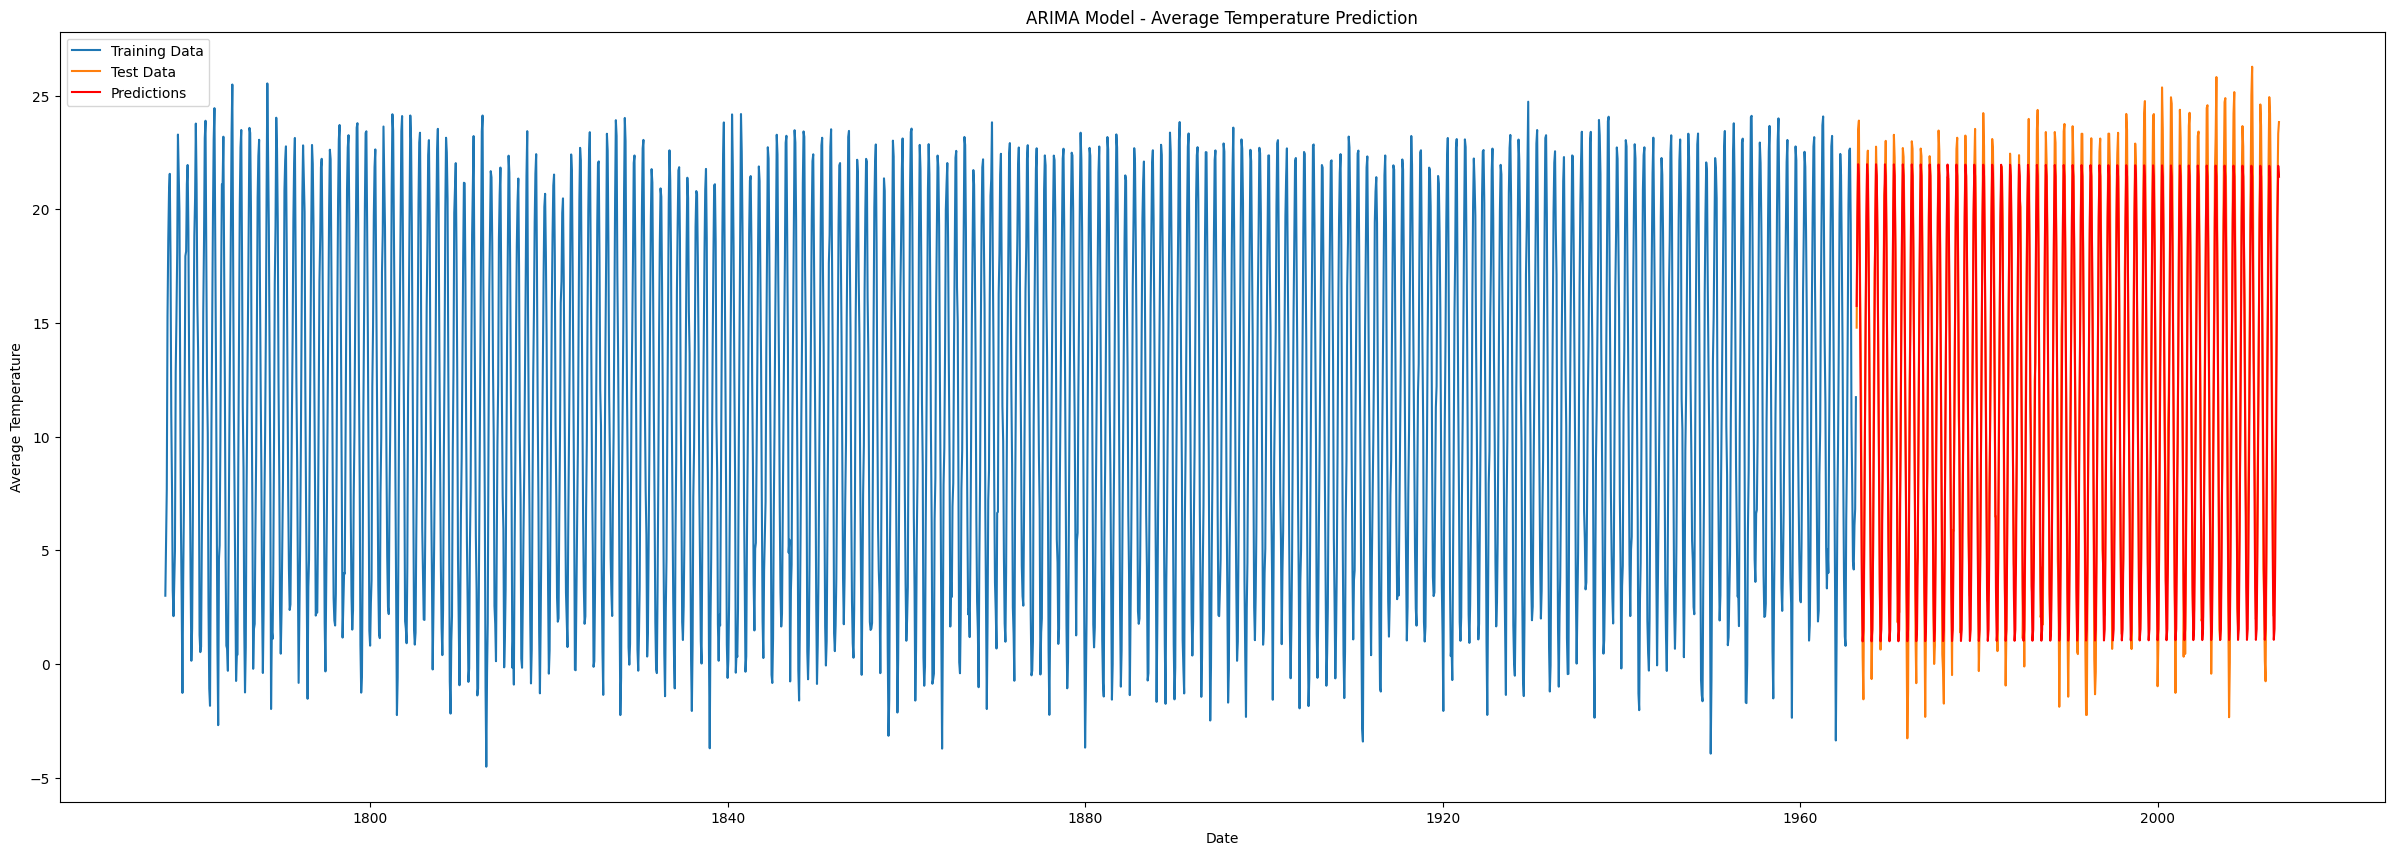

In [12]:
plt.figure(figsize=(30, 10))
plt.plot(train_data.index, train_data['AverageTemperature'], label='Training Data')
plt.plot(test_data.index, test_data['AverageTemperature'], label='Test Data')
plt.plot(test_data.index, predictions, label='Predictions', color='red')
plt.title('ARIMA Model - Average Temperature Prediction')
plt.xlabel('Date')
plt.ylabel('Average Temperature')
plt.legend()
plt.show()

In [13]:
predictions

2270    15.748711
2271    19.682103
2272    21.983816
2273    21.473050
2274    18.286719
          ...    
2833     9.649793
2834    15.108845
2835    19.597412
2836    21.912861
2837    21.434844
Name: predicted_mean, Length: 568, dtype: float64

In [14]:
forecast_period = 10
future_forecast = arima_result.get_prediction(start=len(train_data), end=len(train_data) + forecast_period - 1, dynamic=False)
print(future_forecast.predicted_mean)# Önceki veri setinizin son tarihini bulun
last_date = td['Date'].max()

# Gelecekteki tarihleri oluşturun
future_dates = [last_date + timedelta(days=i) for i in range(1, len(future_forecast.predicted_mean) + 1)]

# Tahmin edilen değerleri içeren bir DataFrame oluşturun
future_predictions_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Temperature': future_forecast.predicted_mean
})

# Sonuçları göster
print(future_predictions_df)


2270    15.748711
2271    19.682103
2272    21.983816
2273    21.473050
2274    18.286719
2275    13.278611
2276     7.790622
2277     3.293194
2278     0.991334
2279     1.501749
Name: predicted_mean, dtype: float64
           Date  Predicted_Temperature
2270 2013-08-02              15.748711
2271 2013-08-03              19.682103
2272 2013-08-04              21.983816
2273 2013-08-05              21.473050
2274 2013-08-06              18.286719
2275 2013-08-07              13.278611
2276 2013-08-08               7.790622
2277 2013-08-09               3.293194
2278 2013-08-10               0.991334
2279 2013-08-11               1.501749


In [15]:

print(len(test_data))

print(len(predictions))



568
568


In [17]:

prediction_df = pd.DataFrame({
    'Date': test_data.index,
    'Actual_Temperature': test_data['AverageTemperature'].values,  
    'Predicted_Temperature': predictions
})

prediction_df

,Date,Actual_Temperature,Predicted_Temperature
2270,1966-05-01,14.793,15.748711
2271,1966-06-01,19.593,19.682103
2272,1966-07-01,23.515,21.983816
2273,1966-08-01,23.903,21.473050
2274,1966-09-01,18.564,18.286719
...,...,...,...
2833,2013-04-01,12.102,9.649793
2834,2013-05-01,17.522,15.108845
2835,2013-06-01,20.862,19.597412
2836,2013-07-01,23.335,21.912861
